In [1]:
import importlib
import optuna

In [2]:
from analysis_functions import *

In [3]:
importlib.reload(sys.modules['analysis_functions'])
from analysis_functions import *

In [4]:
X_stress_components_new = opener('X_stress_components_new', path_import='./resourses/')
X_strain_components_new = opener('X_strain_components_new', path_import='./resourses/')
y_stress_components_new = opener('y_stress_components_new', path_import='./resourses/')
y_strain_components_new = opener('y_strain_components_new', path_import='./resourses/')
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')

./resourses//X_stress_components_new.pkl
./resourses//X_strain_components_new.pkl
./resourses//y_stress_components_new.pkl
./resourses//y_strain_components_new.pkl


In [5]:
X_stress_components_new.shape

(3, 2678, 5)

In [6]:
component_num = 1
n_trials = 200

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [8]:
import shutil

def plot_results(x, y, model_name, do_zip=False, dpi=500, delete_and_rewrite=True):
    cur_X_test, cur_y_test, *_ = get_train_test(x, y)

    model = opener(model_name)
    cur_prediction = model.predict(cur_X_test)
    print('rmse = ', np.sqrt(mean_squared_error(cur_y_test, cur_prediction)))
    
    if delete_and_rewrite:
        os.makedirs(model_name, exist_ok=True)
    
    for i, item in enumerate(cur_X_test[::20]):
        fig = plt.figure(figsize=(5, 4))
        plt.plot(
            cur_X_test[i*20:(i+1)*20, -1],
            cur_prediction[i*20:(i+1)*20],
            '-o',
            label='predicted'
        )
        plt.plot(
            cur_X_test[i*20:(i+1)*20, -1],
            cur_y_test[i*20:(i+1)*20],
            '-o',
            label='real'
        )
        title = f'red {item[0]}, cal {item[1]}, alpha {int(item[2])}, fric {item[3]}'
        plt.title(title)
        plt.legend(loc='best')
        plt.xlabel('r, -')
        plt.ylabel('$\sigma$, MPa')
        # plt.show()
        plt.savefig(''.join((model_name, '/', title, '.png')), format='png', dpi=dpi)
        plt.close()
        # break
    if do_zip: shutil.make_archive(model_name, 'zip', model_name)

In [9]:
X_stress_components_new[0].max(axis=0)

array([ 0.25,  1.  , 20.  ,  0.1 , 40.  ])

# KAN 

In [10]:
from kan import KAN

In [11]:
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X_stress_components_new[0], y_stress_components_new[0])
)

In [12]:
train_list_X[0].shape, train_list_y[0].shape

((37480, 6), (37480,))

In [13]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_x = [train_list_X[0], val_list_X[0]] # a list of numpy arrays
my_x = train_list_X[0].T # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)
my_y = [train_list_y[0], val_list_y[0]] # another list of numpy arrays (targets)
my_y = train_list_y[0] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

test_tensor_x = torch.Tensor(cur_X_test.T)
test_tensor_y = torch.Tensor(cur_y_test)

# my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
# my_dataloader = DataLoader(my_dataset) # create your dataloader

my_dataset = {
    'train_input': tensor_x,
    'test_input': test_tensor_x,
    'train_label': tensor_y,
    'test_label': test_tensor_y
}


x_train = train_list_X[0].T
x_val = val_list_X[0]

y_train = train_list_y[0].T
y_val = val_list_y[0]

x_test = cur_X_test.T
y_test = cur_y_test


train_dataset = {
    "train_input": torch.Tensor(x_train),
    "test_input": torch.Tensor(x_val),
    "train_label": torch.Tensor(y_train),
    "test_label": torch.Tensor(y_val),
}


In [14]:
def prepare_my_dataset(X_stress_components_new, y_stress_components_new):
    """Generate dataset for training and testing KAN model"""
    cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
        split_transform_one_comp_cv(X_stress_components_new, y_stress_components_new)
    )

    tensor_x = torch.Tensor(train_list_X[0].T)
    tensor_y = torch.Tensor(train_list_y[0])

    test_tensor_x = torch.Tensor(cur_X_test.T)
    test_tensor_y = torch.Tensor(cur_y_test)

    my_dataset = {
        "train_input": tensor_x,
        "test_input": test_tensor_x,
        "train_label": tensor_y,
        "test_label": test_tensor_y,
    }
    return my_dataset

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 10)
    n_steps = trial.suggest_int("n_steps", 1, 1000)
    seed = RANDOM_STATE

    inner_layers_config = []
    for n_neurons in range(1, n_layers + 1):
        inner_layers_config.append(trial.suggest_int(f"n_neurons_{n_neurons}", 1, 10))
    
    try:
        # Create a new KAN model with suggested hyperparameters
        model = KAN(width=[6] + inner_layers_config + [1], seed=seed)
        print(f"Current configuration: {inner_layers_config}")
        # Train the model
        result = model.fit(train_dataset, opt="LBFGS", steps=n_steps)

        # # Predict the output
        # prediction = model(train_dataset["test_input"].T).detach().numpy().ravel()

        # ground_truth = train_dataset["test_label"].detach().numpy()

        # rmse = np.sqrt(mean_squared_error(ground_truth, prediction))
        rmse = result["test_loss"][-1]
    except Exception as e:
        print(f"Error: {e}")
        rmse = np.inf

    return rmse

# Use Optuna to tune the hyperparameters of the KAN
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Get the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)



[I 2025-03-29 20:19:06,270] A new study created in memory with name: no-name-c2b72fe6-b39b-4e6f-9893-775e114676ac


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7]


| train_loss: 8.49e+00 | test_loss: 2.79e+03 | reg: 9.64e+01 | : 100%|█| 924/924 [00:51<00:00, 18.03
[I 2025-03-29 20:19:57,547] Trial 0 finished with value: 2786.466552734375 and parameters: {'n_layers': 1, 'n_steps': 924, 'n_neurons_1': 7}. Best is trial 0 with value: 2786.466552734375.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9]


| train_loss: 8.47e+00 | test_loss: 3.18e+02 | reg: 4.82e+01 | : 100%|█| 667/667 [00:42<00:00, 15.53
[I 2025-03-29 20:20:40,503] Trial 1 finished with value: 318.1740417480469 and parameters: {'n_layers': 1, 'n_steps': 667, 'n_neurons_1': 9}. Best is trial 1 with value: 318.1740417480469.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 1, 4, 4]


| train_loss: 6.99e+01 | test_loss: 1.51e+03 | reg: 6.06e+01 | : 100%|█| 604/604 [00:53<00:00, 11.30
[I 2025-03-29 20:21:33,969] Trial 2 finished with value: 1508.1922607421875 and parameters: {'n_layers': 4, 'n_steps': 604, 'n_neurons_1': 10, 'n_neurons_2': 1, 'n_neurons_3': 4, 'n_neurons_4': 4}. Best is trial 1 with value: 318.1740417480469.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 8, 7, 6, 8, 1]


| train_loss: 1.09e+02 | test_loss: 5.66e+01 | reg: 7.66e+01 | : 100%|█| 4/4 [00:01<00:00,  3.81it/s
[I 2025-03-29 20:21:35,063] Trial 3 finished with value: 56.6423225402832 and parameters: {'n_layers': 7, 'n_steps': 4, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 1}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 2, 5, 5]


| train_loss: 8.47e+00 | test_loss: 3.69e+02 | reg: 6.89e+01 | : 100%|█| 567/567 [00:49<00:00, 11.42
[I 2025-03-29 20:22:24,732] Trial 4 finished with value: 369.4984130859375 and parameters: {'n_layers': 4, 'n_steps': 567, 'n_neurons_1': 3, 'n_neurons_2': 2, 'n_neurons_3': 5, 'n_neurons_4': 5}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 10, 2]


| train_loss: 8.47e+00 | test_loss: 9.80e+01 | reg: 5.47e+01 | : 100%|█| 272/272 [00:46<00:00,  5.81
[I 2025-03-29 20:23:11,634] Trial 5 finished with value: 97.99191284179688 and parameters: {'n_layers': 3, 'n_steps': 272, 'n_neurons_1': 6, 'n_neurons_2': 10, 'n_neurons_3': 2}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 10, 4, 7, 4, 1, 2, 3, 6, 5]


| train_loss: 8.48e+00 | test_loss: 8.38e+01 | reg: 3.80e+02 | : 100%|█| 582/582 [02:33<00:00,  3.79
[I 2025-03-29 20:25:45,217] Trial 6 finished with value: 83.81452941894531 and parameters: {'n_layers': 10, 'n_steps': 582, 'n_neurons_1': 8, 'n_neurons_2': 10, 'n_neurons_3': 4, 'n_neurons_4': 7, 'n_neurons_5': 4, 'n_neurons_6': 1, 'n_neurons_7': 2, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 5]


| train_loss: 8.47e+00 | test_loss: 6.21e+02 | reg: 7.49e+01 | : 100%|█| 838/838 [01:38<00:00,  8.51
[I 2025-03-29 20:27:23,732] Trial 7 finished with value: 620.6060791015625 and parameters: {'n_layers': 2, 'n_steps': 838, 'n_neurons_1': 8, 'n_neurons_2': 5}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 9, 6, 4, 4, 2, 4]


| train_loss: 8.47e+00 | test_loss: 8.45e+01 | reg: 8.82e+02 | : 100%|█| 68/68 [00:21<00:00,  3.22it
[I 2025-03-29 20:27:44,922] Trial 8 finished with value: 84.53993225097656 and parameters: {'n_layers': 7, 'n_steps': 68, 'n_neurons_1': 8, 'n_neurons_2': 9, 'n_neurons_3': 6, 'n_neurons_4': 4, 'n_neurons_5': 4, 'n_neurons_6': 2, 'n_neurons_7': 4}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 1, 4, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 51/51 [00:16<00:00,  3.12it/s]
[W 2025-03-29 20:28:01,320] Trial 9 failed with parameters: {'n_layers': 5, 'n_steps': 51, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 1, 'n_neurons_4': 4, 'n_neurons_5': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:28:01,321] Trial 9 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 1, 9]


| train_loss: 8.50e+00 | test_loss: 4.25e+02 | reg: 4.79e+02 | : 100%|█| 326/326 [00:39<00:00,  8.32
[I 2025-03-29 20:28:40,539] Trial 10 finished with value: 425.104736328125 and parameters: {'n_layers': 3, 'n_steps': 326, 'n_neurons_1': 9, 'n_neurons_2': 1, 'n_neurons_3': 9}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 10, 10, 9, 10, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 40/40 [00:14<00:00,  2.81it/s]
[W 2025-03-29 20:28:54,906] Trial 11 failed with parameters: {'n_layers': 7, 'n_steps': 40, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 9, 'n_neurons_6': 10, 'n_neurons_7': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:28:54,907] Trial 11 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 10, 10, 10, 10, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 39/39 [00:13<00:00,  2.98it/s]
[W 2025-03-29 20:29:08,077] Trial 12 failed with parameters: {'n_layers': 7, 'n_steps': 39, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 10, 'n_neurons_6': 10, 'n_neurons_7': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:29:08,078] Trial 12 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 10, 10, 10, 10, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 12/12 [00:03<00:00,  3.02it/s]
[W 2025-03-29 20:29:12,144] Trial 13 failed with parameters: {'n_layers': 7, 'n_steps': 12, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 10, 'n_neurons_6': 10, 'n_neurons_7': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:29:12,145] Trial 13 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 10, 10, 10, 10, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 66/66 [00:20<00:00,  3.20it/s]
[W 2025-03-29 20:29:32,876] Trial 14 failed with parameters: {'n_layers': 7, 'n_steps': 66, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 10, 'n_neurons_6': 10, 'n_neurons_7': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:29:32,877] Trial 14 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 10, 10, 10, 10, 10]


| train_loss: 8.47e+00 | test_loss: 9.28e+01 | reg: 1.55e+02 | : 100%|█| 44/44 [00:12<00:00,  3.40it
[I 2025-03-29 20:29:45,898] Trial 15 finished with value: 92.78324890136719 and parameters: {'n_layers': 7, 'n_steps': 44, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 10, 'n_neurons_6': 10, 'n_neurons_7': 10}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 7, 8, 5, 8, 1, 3, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 393/393 [02:48<00:00,  2.33it/s]
[W 2025-03-29 20:32:34,437] Trial 16 failed with parameters: {'n_layers': 10, 'n_steps': 393, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:32:34,438] Trial 16 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 7, 8, 5, 8, 1, 3, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 438/438 [03:55<00:00,  1.86it/s]
[W 2025-03-29 20:36:30,428] Trial 17 failed with parameters: {'n_layers': 10, 'n_steps': 438, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:36:30,429] Trial 17 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 8, 8, 5, 8, 1, 3, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 379/379 [03:24<00:00,  1.85it/s]
[W 2025-03-29 20:39:55,380] Trial 18 failed with parameters: {'n_layers': 10, 'n_steps': 379, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:39:55,381] Trial 18 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 7, 8, 5, 8, 1, 3, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 362/362 [02:36<00:00,  2.31it/s]
[W 2025-03-29 20:42:32,134] Trial 19 failed with parameters: {'n_layers': 10, 'n_steps': 362, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:42:32,134] Trial 19 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 7, 7, 8, 6, 8, 1, 3, 6, 5]


| train_loss: 8.73e+00 | test_loss: 8.48e+02 | reg: 1.30e+02 | : 100%|█| 377/377 [01:25<00:00,  4.42
[I 2025-03-29 20:43:57,451] Trial 20 finished with value: 848.2378540039062 and parameters: {'n_layers': 10, 'n_steps': 377, 'n_neurons_1': 5, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 6, 'n_neurons_10': 5}. Best is trial 3 with value: 56.6423225402832.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 4, 2, 7, 1, 1, 1, 3, 9, 2]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 3.83e+01 | : 100%|█| 726/726 [01:43<00:00,  6.99
[I 2025-03-29 20:45:41,401] Trial 21 finished with value: 56.64091110229492 and parameters: {'n_layers': 10, 'n_steps': 726, 'n_neurons_1': 4, 'n_neurons_2': 4, 'n_neurons_3': 2, 'n_neurons_4': 7, 'n_neurons_5': 1, 'n_neurons_6': 1, 'n_neurons_7': 1, 'n_neurons_8': 3, 'n_neurons_9': 9, 'n_neurons_10': 2}. Best is trial 21 with value: 56.64091110229492.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 4, 1, 1, 2, 5, 1, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 809/809 [04:10<00:00,  3.24it/s]
[W 2025-03-29 20:49:51,524] Trial 22 failed with parameters: {'n_layers': 8, 'n_steps': 809, 'n_neurons_1': 4, 'n_neurons_2': 4, 'n_neurons_3': 1, 'n_neurons_4': 1, 'n_neurons_5': 2, 'n_neurons_6': 5, 'n_neurons_7': 1, 'n_neurons_8': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:49:51,525] Trial 22 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 4, 1, 7, 1, 5, 1, 10]


| train_loss: 8.48e+00 | test_loss: 8.02e+01 | reg: 9.83e+01 | : 100%|█| 814/814 [01:53<00:00,  7.15
[I 2025-03-29 20:51:45,492] Trial 23 finished with value: 80.24340057373047 and parameters: {'n_layers': 8, 'n_steps': 814, 'n_neurons_1': 4, 'n_neurons_2': 4, 'n_neurons_3': 1, 'n_neurons_4': 7, 'n_neurons_5': 1, 'n_neurons_6': 5, 'n_neurons_7': 1, 'n_neurons_8': 10}. Best is trial 21 with value: 56.64091110229492.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 8, 1, 7, 6, 5, 1]


| train_loss: 4.84e+01 | test_loss: 7.62e+01 | reg: 4.57e+02 | : 100%|█| 744/744 [02:26<00:00,  5.08
[I 2025-03-29 20:54:11,924] Trial 24 finished with value: 76.242919921875 and parameters: {'n_layers': 8, 'n_steps': 744, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 1, 'n_neurons_5': 7, 'n_neurons_6': 6, 'n_neurons_7': 5, 'n_neurons_8': 1}. Best is trial 21 with value: 56.64091110229492.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 3, 9, 1, 4]


| train_loss: 8.47e+00 | test_loss: 1.20e+02 | reg: 2.93e+02 | : 100%|█| 196/196 [00:29<00:00,  6.63
[I 2025-03-29 20:54:41,587] Trial 25 finished with value: 119.81018829345703 and parameters: {'n_layers': 6, 'n_steps': 196, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 3, 'n_neurons_4': 9, 'n_neurons_5': 1, 'n_neurons_6': 4}. Best is trial 21 with value: 56.64091110229492.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 3, 7, 6, 8, 8, 8, 7, 10]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 4.40e+01 | : 100%|█| 434/434 [01:27<00:00,  4.98
[I 2025-03-29 20:56:08,864] Trial 26 finished with value: 56.637359619140625 and parameters: {'n_layers': 9, 'n_steps': 434, 'n_neurons_1': 3, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 8, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 26 with value: 56.637359619140625.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 9, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 452/452 [02:34<00:00,  2.93it/s]
[W 2025-03-29 20:58:43,050] Trial 27 failed with parameters: {'n_layers': 9, 'n_steps': 452, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 20:58:43,051] Trial 27 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 440/440 [02:25<00:00,  3.02it/s]
[W 2025-03-29 21:01:08,792] Trial 28 failed with parameters: {'n_layers': 9, 'n_steps': 440, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:01:08,793] Trial 28 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 6, 2, 9, 7, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 394/394 [02:07<00:00,  3.10it/s]
[W 2025-03-29 21:03:16,101] Trial 29 failed with parameters: {'n_layers': 9, 'n_steps': 394, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:03:16,102] Trial 29 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 439/439 [02:26<00:00,  2.99it/s]
[W 2025-03-29 21:05:42,798] Trial 30 failed with parameters: {'n_layers': 9, 'n_steps': 439, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:05:42,798] Trial 30 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 407/407 [02:16<00:00,  2.97it/s]
[W 2025-03-29 21:07:59,856] Trial 31 failed with parameters: {'n_layers': 9, 'n_steps': 407, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:07:59,856] Trial 31 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 8, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 447/447 [02:29<00:00,  3.00it/s]
[W 2025-03-29 21:10:29,009] Trial 32 failed with parameters: {'n_layers': 9, 'n_steps': 447, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:10:29,010] Trial 32 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 8, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 454/454 [02:30<00:00,  3.01it/s]
[W 2025-03-29 21:12:59,753] Trial 33 failed with parameters: {'n_layers': 9, 'n_steps': 454, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:12:59,754] Trial 33 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 7, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 459/459 [02:32<00:00,  3.02it/s]
[W 2025-03-29 21:15:32,012] Trial 34 failed with parameters: {'n_layers': 9, 'n_steps': 459, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:15:32,013] Trial 34 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 2, 9, 8, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 464/464 [02:29<00:00,  3.10it/s]
[W 2025-03-29 21:18:01,628] Trial 35 failed with parameters: {'n_layers': 9, 'n_steps': 464, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:18:01,629] Trial 35 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 5, 9, 7, 8, 7, 10]


| train_loss: 5.59e+01 | test_loss: 5.66e+01 | reg: 2.34e+01 | : 100%|█| 447/447 [00:58<00:00,  7.63
[I 2025-03-29 21:19:00,342] Trial 36 finished with value: 56.63081741333008 and parameters: {'n_layers': 9, 'n_steps': 447, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 5, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 36 with value: 56.63081741333008.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 3, 9, 8, 9, 8, 10]


| train_loss: 8.09e+01 | test_loss: 5.66e+01 | reg: 2.12e+03 | : 100%|█| 454/454 [01:16<00:00,  5.94
[I 2025-03-29 21:20:16,872] Trial 37 finished with value: 56.580291748046875 and parameters: {'n_layers': 9, 'n_steps': 454, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 3, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 9, 'n_neurons_8': 8, 'n_neurons_9': 10}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 6, 2, 10, 7, 8, 8, 1]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 1.39e+01 | : 100%|█| 481/481 [01:13<00:00,  6.52
[I 2025-03-29 21:21:30,740] Trial 38 finished with value: 56.638790130615234 and parameters: {'n_layers': 9, 'n_steps': 481, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 10, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 1}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 5, 3, 9]


| train_loss: 1.08e+02 | test_loss: 5.67e+01 | reg: 1.65e+01 | : 100%|█| 189/189 [00:23<00:00,  8.17
[I 2025-03-29 21:21:53,932] Trial 39 finished with value: 56.66325378417969 and parameters: {'n_layers': 5, 'n_steps': 189, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 5, 'n_neurons_4': 3, 'n_neurons_5': 9}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 468/468 [02:38<00:00,  2.95it/s]
[W 2025-03-29 21:24:32,655] Trial 40 failed with parameters: {'n_layers': 9, 'n_steps': 468, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:24:32,656] Trial 40 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 453/453 [02:30<00:00,  3.01it/s]
[W 2025-03-29 21:27:03,346] Trial 41 failed with parameters: {'n_layers': 9, 'n_steps': 453, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:27:03,347] Trial 41 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 438/438 [02:25<00:00,  3.00it/s]
[W 2025-03-29 21:29:29,362] Trial 42 failed with parameters: {'n_layers': 9, 'n_steps': 438, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:29:29,363] Trial 42 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 426/426 [02:21<00:00,  3.01it/s]
[W 2025-03-29 21:31:50,784] Trial 43 failed with parameters: {'n_layers': 9, 'n_steps': 426, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:31:50,784] Trial 43 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 432/432 [02:24<00:00,  3.00it/s]
[W 2025-03-29 21:34:14,889] Trial 44 failed with parameters: {'n_layers': 9, 'n_steps': 432, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:34:14,889] Trial 44 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 444/444 [02:27<00:00,  3.02it/s]
[W 2025-03-29 21:36:42,207] Trial 45 failed with parameters: {'n_layers': 9, 'n_steps': 444, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:36:42,208] Trial 45 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 446/446 [02:27<00:00,  3.03it/s]
[W 2025-03-29 21:39:09,602] Trial 46 failed with parameters: {'n_layers': 9, 'n_steps': 446, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:39:09,603] Trial 46 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 440/440 [02:25<00:00,  3.03it/s]
[W 2025-03-29 21:41:35,020] Trial 47 failed with parameters: {'n_layers': 9, 'n_steps': 440, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:41:35,021] Trial 47 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 444/444 [02:27<00:00,  3.02it/s]
[W 2025-03-29 21:44:02,251] Trial 48 failed with parameters: {'n_layers': 9, 'n_steps': 444, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:44:02,252] Trial 48 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 490/490 [02:38<00:00,  3.10it/s]
[W 2025-03-29 21:46:40,634] Trial 49 failed with parameters: {'n_layers': 9, 'n_steps': 490, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:46:40,635] Trial 49 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 422/422 [02:15<00:00,  3.12it/s]
[W 2025-03-29 21:48:56,161] Trial 50 failed with parameters: {'n_layers': 9, 'n_steps': 422, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:48:56,162] Trial 50 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 5, 8, 10, 8, 7, 9]


| train_loss: 8.47e+00 | test_loss: 7.03e+01 | reg: 1.01e+02 | : 100%|█| 459/459 [01:10<00:00,  6.49
[I 2025-03-29 21:50:06,981] Trial 51 finished with value: 70.32764434814453 and parameters: {'n_layers': 9, 'n_steps': 459, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 10, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 9}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 3, 8, 8, 8, 7, 10]


| train_loss: 6.10e+01 | test_loss: 8.18e+03 | reg: 4.30e+02 | : 100%|█| 406/406 [01:04<00:00,  6.26
[I 2025-03-29 21:51:11,892] Trial 52 finished with value: 8183.484375 and parameters: {'n_layers': 9, 'n_steps': 406, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 2, 6, 6, 8, 9, 10, 9]


| train_loss: 8.50e+00 | test_loss: 4.72e+02 | reg: 1.96e+02 | : 100%|█| 516/516 [01:05<00:00,  7.84
[I 2025-03-29 21:52:17,808] Trial 53 finished with value: 472.2579345703125 and parameters: {'n_layers': 8, 'n_steps': 516, 'n_neurons_1': 3, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 6, 'n_neurons_5': 8, 'n_neurons_6': 9, 'n_neurons_7': 10, 'n_neurons_8': 9}. Best is trial 37 with value: 56.580291748046875.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 4, 9, 6, 7, 6, 10]


| train_loss: 1.08e+02 | test_loss: 5.62e+01 | reg: 1.09e+02 | : 100%|█| 304/304 [00:45<00:00,  6.68
[I 2025-03-29 21:53:03,393] Trial 54 finished with value: 56.16022491455078 and parameters: {'n_layers': 9, 'n_steps': 304, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 9, 'n_neurons_6': 6, 'n_neurons_7': 7, 'n_neurons_8': 6, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 4, 10, 6, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 249/249 [01:11<00:00,  3.49it/s]
[W 2025-03-29 21:54:14,787] Trial 55 failed with parameters: {'n_layers': 8, 'n_steps': 249, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 4, 'n_neurons_5': 10, 'n_neurons_6': 6, 'n_neurons_7': 6, 'n_neurons_8': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:54:14,787] Trial 55 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 4, 10, 6, 6, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 286/286 [01:20<00:00,  3.57it/s]
[W 2025-03-29 21:55:35,001] Trial 56 failed with parameters: {'n_layers': 8, 'n_steps': 286, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 4, 'n_neurons_5': 10, 'n_neurons_6': 6, 'n_neurons_7': 6, 'n_neurons_8': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:55:35,001] Trial 56 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 4, 10, 6]


| train_loss: 1.09e+02 | test_loss: 5.66e+01 | reg: 2.97e+01 | : 100%|█| 255/255 [00:28<00:00,  8.91
[I 2025-03-29 21:56:03,699] Trial 57 finished with value: 56.646827697753906 and parameters: {'n_layers': 6, 'n_steps': 255, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 10, 'n_neurons_6': 6}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 10, 2, 9, 4, 7, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 345/345 [01:36<00:00,  3.58it/s]
[W 2025-03-29 21:57:40,027] Trial 58 failed with parameters: {'n_layers': 8, 'n_steps': 345, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 4, 'n_neurons_7': 7, 'n_neurons_8': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:57:40,027] Trial 58 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 10, 2, 9, 5, 6, 5]


| train_loss: 1.02e+02 | test_loss: 6.08e+01 | reg: 1.10e+02 | : 100%|█| 339/339 [00:49<00:00,  6.92
[I 2025-03-29 21:58:29,121] Trial 59 finished with value: 60.84469223022461 and parameters: {'n_layers': 8, 'n_steps': 339, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 5, 'n_neurons_7': 6, 'n_neurons_8': 5}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 5, 3, 9, 7, 7, 5, 8, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 142/142 [00:47<00:00,  3.00it/s]
[W 2025-03-29 21:59:16,491] Trial 60 failed with parameters: {'n_layers': 10, 'n_steps': 142, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 5, 'n_neurons_4': 3, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 7, 'n_neurons_8': 5, 'n_neurons_9': 8, 'n_neurons_10': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 21:59:16,492] Trial 60 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 9, 3, 9, 7, 7, 5, 8, 10]


| train_loss: 1.08e+01 | test_loss: 1.86e+02 | reg: 9.71e+02 | : 100%|█| 137/137 [00:27<00:00,  4.98
[I 2025-03-29 21:59:44,084] Trial 61 finished with value: 185.7135772705078 and parameters: {'n_layers': 10, 'n_steps': 137, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 9, 'n_neurons_4': 3, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 7, 'n_neurons_8': 5, 'n_neurons_9': 8, 'n_neurons_10': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 5, 5, 7, 4, 9, 6, 8]


| train_loss: 1.82e+02 | test_loss: 1.27e+04 | reg: 9.71e+02 | : 100%|█| 306/306 [00:47<00:00,  6.50
[I 2025-03-29 22:00:31,230] Trial 62 finished with value: 12683.2060546875 and parameters: {'n_layers': 9, 'n_steps': 306, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 5, 'n_neurons_4': 5, 'n_neurons_5': 7, 'n_neurons_6': 4, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 4, 1, 4, 7, 6]


| train_loss: 8.47e+00 | test_loss: 1.28e+02 | reg: 2.80e+02 | : 100%|█| 949/949 [02:06<00:00,  7.52
[I 2025-03-29 22:02:37,471] Trial 63 finished with value: 127.69712829589844 and parameters: {'n_layers': 7, 'n_steps': 949, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 4, 'n_neurons_4': 1, 'n_neurons_5': 4, 'n_neurons_6': 7, 'n_neurons_7': 6}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 6, 9, 4, 7, 9, 9, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 505/505 [02:27<00:00,  3.42it/s]
[W 2025-03-29 22:05:05,301] Trial 64 failed with parameters: {'n_layers': 8, 'n_steps': 505, 'n_neurons_1': 6, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 9, 'n_neurons_7': 9, 'n_neurons_8': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:05:05,302] Trial 64 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 8, 9, 4, 7, 9, 9, 9]


| train_loss: 5.27e+01 | test_loss: 2.07e+02 | reg: 1.72e+02 | : 100%|█| 521/521 [01:25<00:00,  6.07
[I 2025-03-29 22:06:31,272] Trial 65 finished with value: 207.25389099121094 and parameters: {'n_layers': 8, 'n_steps': 521, 'n_neurons_1': 6, 'n_neurons_2': 8, 'n_neurons_3': 9, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 9, 'n_neurons_7': 9, 'n_neurons_8': 9}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 3, 7, 6, 9, 7, 7, 7, 10]


| train_loss: 1.29e+02 | test_loss: 3.22e+04 | reg: 3.04e+02 | : 100%|█| 420/420 [01:03<00:00,  6.62
[I 2025-03-29 22:07:34,801] Trial 66 finished with value: 32216.744140625 and parameters: {'n_layers': 9, 'n_steps': 420, 'n_neurons_1': 3, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 7, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 6, 6, 8, 9, 9, 6, 10]


| train_loss: 8.47e+00 | test_loss: 8.91e+01 | reg: 1.06e+03 | : 100%|█| 439/439 [01:17<00:00,  5.69
[I 2025-03-29 22:08:51,978] Trial 67 finished with value: 89.0585708618164 and parameters: {'n_layers': 9, 'n_steps': 439, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 6, 'n_neurons_4': 6, 'n_neurons_5': 8, 'n_neurons_6': 9, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 8, 5, 10, 6, 7, 8, 10, 9]


| train_loss: 8.47e+00 | test_loss: 6.54e+01 | reg: 1.07e+02 | : 100%|█| 650/650 [01:45<00:00,  6.15
[I 2025-03-29 22:10:37,770] Trial 68 finished with value: 65.43350219726562 and parameters: {'n_layers': 10, 'n_steps': 650, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 5, 'n_neurons_5': 10, 'n_neurons_6': 6, 'n_neurons_7': 7, 'n_neurons_8': 8, 'n_neurons_9': 10, 'n_neurons_10': 9}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 4, 7, 2, 9, 8, 8, 8]


| train_loss: 8.47e+00 | test_loss: 9.80e+01 | reg: 1.63e+02 | : 100%|█| 375/375 [00:54<00:00,  6.86
[I 2025-03-29 22:11:32,508] Trial 69 finished with value: 98.00679016113281 and parameters: {'n_layers': 8, 'n_steps': 375, 'n_neurons_1': 3, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 8}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 543/543 [02:44<00:00,  3.30it/s]
[W 2025-03-29 22:14:17,123] Trial 70 failed with parameters: {'n_layers': 9, 'n_steps': 543, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:14:17,123] Trial 70 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 241/241 [01:13<00:00,  3.26it/s]
[W 2025-03-29 22:15:31,200] Trial 71 failed with parameters: {'n_layers': 9, 'n_steps': 241, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:15:31,200] Trial 71 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 215/215 [01:07<00:00,  3.17it/s]
[W 2025-03-29 22:16:39,203] Trial 72 failed with parameters: {'n_layers': 9, 'n_steps': 215, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:16:39,203] Trial 72 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 543/543 [02:48<00:00,  3.23it/s]
[W 2025-03-29 22:19:27,340] Trial 73 failed with parameters: {'n_layers': 9, 'n_steps': 543, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:19:27,341] Trial 73 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 526/526 [02:43<00:00,  3.22it/s]
[W 2025-03-29 22:22:10,871] Trial 74 failed with parameters: {'n_layers': 9, 'n_steps': 526, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:22:10,871] Trial 74 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 537/537 [02:52<00:00,  3.11it/s]
[W 2025-03-29 22:25:03,673] Trial 75 failed with parameters: {'n_layers': 9, 'n_steps': 537, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:25:03,674] Trial 75 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 238/238 [01:17<00:00,  3.09it/s]
[W 2025-03-29 22:26:20,890] Trial 76 failed with parameters: {'n_layers': 9, 'n_steps': 238, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:26:20,890] Trial 76 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 531/531 [02:48<00:00,  3.16it/s]
[W 2025-03-29 22:29:09,055] Trial 77 failed with parameters: {'n_layers': 9, 'n_steps': 531, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:29:09,056] Trial 77 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 531/531 [02:42<00:00,  3.26it/s]
[W 2025-03-29 22:31:52,078] Trial 78 failed with parameters: {'n_layers': 9, 'n_steps': 531, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:31:52,079] Trial 78 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 651/651 [03:19<00:00,  3.26it/s]
[W 2025-03-29 22:35:11,620] Trial 79 failed with parameters: {'n_layers': 9, 'n_steps': 651, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:35:11,621] Trial 79 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 532/532 [02:42<00:00,  3.28it/s]
[W 2025-03-29 22:37:54,002] Trial 80 failed with parameters: {'n_layers': 9, 'n_steps': 532, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:37:54,003] Trial 80 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 539/539 [02:44<00:00,  3.28it/s]
[W 2025-03-29 22:40:38,364] Trial 81 failed with parameters: {'n_layers': 9, 'n_steps': 539, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:40:38,365] Trial 81 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 231/231 [01:10<00:00,  3.26it/s]
[W 2025-03-29 22:41:49,226] Trial 82 failed with parameters: {'n_layers': 9, 'n_steps': 231, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:41:49,227] Trial 82 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 524/524 [02:40<00:00,  3.27it/s]
[W 2025-03-29 22:44:29,344] Trial 83 failed with parameters: {'n_layers': 9, 'n_steps': 524, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:44:29,345] Trial 83 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 525/525 [02:39<00:00,  3.30it/s]
[W 2025-03-29 22:47:08,681] Trial 84 failed with parameters: {'n_layers': 9, 'n_steps': 525, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:47:08,682] Trial 84 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 3, 8, 7, 9, 6, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 544/544 [02:44<00:00,  3.30it/s]
[W 2025-03-29 22:49:53,751] Trial 85 failed with parameters: {'n_layers': 9, 'n_steps': 544, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:49:53,751] Trial 85 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 4, 8, 7, 9, 6, 8]


| train_loss: 8.47e+00 | test_loss: 8.10e+01 | reg: 1.02e+02 | : 100%|█| 532/532 [01:10<00:00,  7.53
[I 2025-03-29 22:51:04,448] Trial 86 finished with value: 80.99916076660156 and parameters: {'n_layers': 9, 'n_steps': 532, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 8}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 5, 3, 9, 9, 7]


| train_loss: 1.08e+01 | test_loss: 7.94e+02 | reg: 3.40e+02 | : 100%|█| 632/632 [01:18<00:00,  8.07
[I 2025-03-29 22:52:22,831] Trial 87 finished with value: 794.0115356445312 and parameters: {'n_layers': 7, 'n_steps': 632, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 5, 'n_neurons_4': 3, 'n_neurons_5': 9, 'n_neurons_6': 9, 'n_neurons_7': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 6, 4, 6, 5, 5, 7, 3, 1]


| train_loss: 6.62e+01 | test_loss: 7.68e+02 | reg: 2.92e+02 | : 100%|█| 273/273 [00:51<00:00,  5.27
[I 2025-03-29 22:53:14,727] Trial 88 finished with value: 768.2548217773438 and parameters: {'n_layers': 10, 'n_steps': 273, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 6, 'n_neurons_4': 4, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 5, 'n_neurons_8': 7, 'n_neurons_9': 3, 'n_neurons_10': 1}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 2, 7, 6, 7, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 581/581 [02:14<00:00,  4.32it/s]
[W 2025-03-29 22:55:29,211] Trial 89 failed with parameters: {'n_layers': 6, 'n_steps': 581, 'n_neurons_1': 4, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:55:29,211] Trial 89 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4]


| train_loss: 8.47e+00 | test_loss: 1.59e+02 | reg: 3.76e+01 | : 100%|█| 573/573 [00:38<00:00, 14.84
[I 2025-03-29 22:56:07,843] Trial 90 finished with value: 158.72445678710938 and parameters: {'n_layers': 1, 'n_steps': 573, 'n_neurons_1': 4}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 7, 6, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 223/223 [00:45<00:00,  4.86it/s]
[W 2025-03-29 22:56:53,826] Trial 91 failed with parameters: {'n_layers': 5, 'n_steps': 223, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:56:53,826] Trial 91 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 7, 6, 7, 8]


| train_loss: 1.07e+02 | test_loss: 5.66e+01 | reg: 2.49e+01 | : 100%|█| 207/207 [00:26<00:00,  7.87
[I 2025-03-29 22:57:20,201] Trial 92 finished with value: 56.64198303222656 and parameters: {'n_layers': 6, 'n_steps': 207, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 8}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 4, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 347/347 [01:09<00:00,  4.98it/s]
[W 2025-03-29 22:58:30,004] Trial 93 failed with parameters: {'n_layers': 5, 'n_steps': 347, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 4, 'n_neurons_4': 8, 'n_neurons_5': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 22:58:30,004] Trial 93 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 4, 8, 10, 6, 10, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 476/476 [02:16<00:00,  3.48it/s]
[W 2025-03-29 23:00:46,712] Trial 94 failed with parameters: {'n_layers': 8, 'n_steps': 476, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 4, 'n_neurons_4': 8, 'n_neurons_5': 10, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:00:46,713] Trial 94 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 4, 5, 10]


| train_loss: 8.47e+00 | test_loss: 8.73e+01 | reg: 3.73e+02 | : 100%|█| 476/476 [00:56<00:00,  8.36
[I 2025-03-29 23:01:43,729] Trial 95 finished with value: 87.3084487915039 and parameters: {'n_layers': 5, 'n_steps': 476, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 4, 'n_neurons_4': 5, 'n_neurons_5': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 6, 2, 10, 7, 8, 8, 1]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 1.39e+01 | : 100%|█| 477/477 [01:09<00:00,  6.84
[I 2025-03-29 23:02:53,530] Trial 96 finished with value: 56.638790130615234 and parameters: {'n_layers': 9, 'n_steps': 477, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 10, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 1}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 6, 2, 9, 8, 8, 8, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 368/368 [01:54<00:00,  3.23it/s]
[W 2025-03-29 23:04:47,669] Trial 97 failed with parameters: {'n_layers': 9, 'n_steps': 368, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:04:47,670] Trial 97 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 6, 2, 9, 8, 8, 8, 1]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 7.94e+01 | : 100%|█| 365/365 [00:50<00:00,  7.16
[I 2025-03-29 23:05:38,722] Trial 98 finished with value: 56.63905715942383 and parameters: {'n_layers': 9, 'n_steps': 365, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 1}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 1, 5, 3, 10, 6, 9, 7, 4, 7]


| train_loss: 8.47e+00 | test_loss: 6.46e+01 | reg: 9.06e+01 | : 100%|█| 419/419 [01:10<00:00,  5.98
[I 2025-03-29 23:06:48,869] Trial 99 finished with value: 64.58831787109375 and parameters: {'n_layers': 10, 'n_steps': 419, 'n_neurons_1': 3, 'n_neurons_2': 1, 'n_neurons_3': 5, 'n_neurons_4': 3, 'n_neurons_5': 10, 'n_neurons_6': 6, 'n_neurons_7': 9, 'n_neurons_8': 7, 'n_neurons_9': 4, 'n_neurons_10': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 2, 8, 4, 10, 7, 7, 9]


| train_loss: 3.60e+01 | test_loss: 5.99e+03 | reg: 8.04e+02 | : 100%|█| 550/550 [01:30<00:00,  6.06
[I 2025-03-29 23:08:19,658] Trial 100 finished with value: 5991.1396484375 and parameters: {'n_layers': 8, 'n_steps': 550, 'n_neurons_1': 10, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 10, 'n_neurons_6': 7, 'n_neurons_7': 7, 'n_neurons_8': 9}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 7, 7, 8, 6, 10, 5, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 307/307 [01:37<00:00,  3.14it/s]
[W 2025-03-29 23:09:57,447] Trial 101 failed with parameters: {'n_layers': 9, 'n_steps': 307, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 8, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 5, 'n_neurons_9': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:09:57,447] Trial 101 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 7, 7, 5, 6, 10, 5, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 316/316 [01:36<00:00,  3.28it/s]
[W 2025-03-29 23:11:33,730] Trial 102 failed with parameters: {'n_layers': 9, 'n_steps': 316, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 5, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 5, 'n_neurons_9': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:11:33,731] Trial 102 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 7, 7, 8, 6, 10, 5, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 596/596 [03:09<00:00,  3.15it/s]
[W 2025-03-29 23:14:43,167] Trial 103 failed with parameters: {'n_layers': 9, 'n_steps': 596, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 8, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 5, 'n_neurons_9': 9} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:14:43,168] Trial 103 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 7, 1, 8, 7, 10, 5, 9]


| train_loss: 8.47e+00 | test_loss: 9.41e+01 | reg: 2.52e+02 | : 100%|█| 593/593 [01:26<00:00,  6.86
[I 2025-03-29 23:16:09,685] Trial 104 finished with value: 94.06344604492188 and parameters: {'n_layers': 9, 'n_steps': 593, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 1, 'n_neurons_5': 8, 'n_neurons_6': 7, 'n_neurons_7': 10, 'n_neurons_8': 5, 'n_neurons_9': 9}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 5, 5, 8, 8, 6, 9, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 301/301 [01:41<00:00,  2.98it/s]
[W 2025-03-29 23:17:50,854] Trial 105 failed with parameters: {'n_layers': 10, 'n_steps': 301, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 5, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:17:50,854] Trial 105 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 7, 3, 8, 8, 6, 9, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 303/303 [01:39<00:00,  3.06it/s]
[W 2025-03-29 23:19:30,070] Trial 106 failed with parameters: {'n_layers': 10, 'n_steps': 303, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 7, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:19:30,071] Trial 106 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 6, 7, 5, 8, 8, 6, 9, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 313/313 [01:43<00:00,  3.03it/s]
[W 2025-03-29 23:21:13,584] Trial 107 failed with parameters: {'n_layers': 10, 'n_steps': 313, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 7, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:21:13,584] Trial 107 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 3, 6, 8, 9, 8, 8, 6, 9, 3]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 6.49e+01 | : 100%|█| 322/322 [00:44<00:00,  7.30
[I 2025-03-29 23:21:57,776] Trial 108 finished with value: 56.638710021972656 and parameters: {'n_layers': 10, 'n_steps': 322, 'n_neurons_1': 7, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 8, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 3, 9, 8, 5, 8, 9, 6, 9, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 305/305 [01:46<00:00,  2.86it/s]
[W 2025-03-29 23:23:44,526] Trial 109 failed with parameters: {'n_layers': 10, 'n_steps': 305, 'n_neurons_1': 7, 'n_neurons_2': 3, 'n_neurons_3': 9, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 9, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:23:44,526] Trial 109 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 3, 9, 8, 5, 8, 6, 6, 9, 3]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 6.34e+01 | : 100%|█| 297/297 [00:50<00:00,  5.83
[I 2025-03-29 23:24:35,589] Trial 110 finished with value: 56.6385383605957 and parameters: {'n_layers': 10, 'n_steps': 297, 'n_neurons_1': 7, 'n_neurons_2': 3, 'n_neurons_3': 9, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 5, 9, 9, 5, 9, 6, 4, 10, 3]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 5.34e+01 | : 100%|█| 241/241 [00:37<00:00,  6.47
[I 2025-03-29 23:25:12,961] Trial 111 finished with value: 56.64065170288086 and parameters: {'n_layers': 10, 'n_steps': 241, 'n_neurons_1': 7, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 5, 'n_neurons_6': 9, 'n_neurons_7': 6, 'n_neurons_8': 4, 'n_neurons_9': 10, 'n_neurons_10': 3}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 9, 8, 5, 10, 5, 6]


| train_loss: 1.08e+02 | test_loss: 5.66e+01 | reg: 6.09e+01 | : 100%|█| 699/699 [01:40<00:00,  6.99
[I 2025-03-29 23:26:53,081] Trial 112 finished with value: 56.63880920410156 and parameters: {'n_layers': 8, 'n_steps': 699, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 9, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 10, 'n_neurons_7': 5, 'n_neurons_8': 6}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 6, 8, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 133/133 [00:24<00:00,  5.47it/s]
[W 2025-03-29 23:27:17,465] Trial 113 failed with parameters: {'n_layers': 4, 'n_steps': 133, 'n_neurons_1': 6, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:27:17,466] Trial 113 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 6, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 130/130 [00:20<00:00,  6.28it/s]
[W 2025-03-29 23:27:38,229] Trial 114 failed with parameters: {'n_layers': 3, 'n_steps': 130, 'n_neurons_1': 6, 'n_neurons_2': 6, 'n_neurons_3': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:27:38,230] Trial 114 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 6, 10, 7, 3, 6, 4, 4, 9, 7]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 5.08e+01 | : 100%|█| 1000/1000 [02:19<00:00,  7.
[I 2025-03-29 23:29:57,567] Trial 115 finished with value: 56.639671325683594 and parameters: {'n_layers': 10, 'n_steps': 1000, 'n_neurons_1': 6, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 7, 'n_neurons_5': 3, 'n_neurons_6': 6, 'n_neurons_7': 4, 'n_neurons_8': 4, 'n_neurons_9': 9, 'n_neurons_10': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 3, 8, 8, 4, 8, 7, 6, 9, 3]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 6.31e+01 | : 100%|█| 310/310 [00:46<00:00,  6.67
[I 2025-03-29 23:30:44,175] Trial 116 finished with value: 56.641841888427734 and parameters: {'n_layers': 10, 'n_steps': 310, 'n_neurons_1': 7, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 4, 'n_neurons_6': 8, 'n_neurons_7': 7, 'n_neurons_8': 6, 'n_neurons_9': 9, 'n_neurons_10': 3}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 7, 9, 6, 8, 6, 7, 10, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 113/113 [00:38<00:00,  2.95it/s]
[W 2025-03-29 23:31:22,594] Trial 117 failed with parameters: {'n_layers': 10, 'n_steps': 113, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:31:22,595] Trial 117 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 7, 9, 3, 8, 8, 7, 10, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 357/357 [02:03<00:00,  2.89it/s]
[W 2025-03-29 23:33:26,344] Trial 118 failed with parameters: {'n_layers': 10, 'n_steps': 357, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:33:26,344] Trial 118 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 3, 7, 9, 3, 8, 6, 7, 10, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 158/158 [00:56<00:00,  2.81it/s]
[W 2025-03-29 23:34:22,602] Trial 119 failed with parameters: {'n_layers': 10, 'n_steps': 158, 'n_neurons_1': 5, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:34:22,603] Trial 119 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 7, 9, 6, 8, 6, 7, 10, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 353/353 [02:04<00:00,  2.84it/s]
[W 2025-03-29 23:36:27,046] Trial 120 failed with parameters: {'n_layers': 10, 'n_steps': 353, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:36:27,046] Trial 120 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 7, 10, 6, 8, 6, 7, 10, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 133/133 [00:46<00:00,  2.88it/s]
[W 2025-03-29 23:37:13,265] Trial 121 failed with parameters: {'n_layers': 10, 'n_steps': 133, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:37:13,266] Trial 121 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 7, 9, 3, 8, 6, 7, 10, 4]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 7.30e+01 | : 100%|█| 136/136 [00:21<00:00,  6.20
[I 2025-03-29 23:37:35,295] Trial 122 finished with value: 56.632686614990234 and parameters: {'n_layers': 10, 'n_steps': 136, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10, 'n_neurons_10': 4}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 3, 8, 6, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 110/110 [00:36<00:00,  2.98it/s]
[W 2025-03-29 23:38:12,328] Trial 123 failed with parameters: {'n_layers': 9, 'n_steps': 110, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:38:12,329] Trial 123 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 2, 8, 6, 7, 10]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 6.44e+01 | : 100%|█| 124/124 [00:24<00:00,  4.98
[I 2025-03-29 23:38:37,332] Trial 124 finished with value: 56.61587905883789 and parameters: {'n_layers': 9, 'n_steps': 124, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 4, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 74/74 [00:23<00:00,  3.21it/s]
[W 2025-03-29 23:39:00,509] Trial 125 failed with parameters: {'n_layers': 9, 'n_steps': 74, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 4, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:39:00,509] Trial 125 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 4, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 124/124 [00:40<00:00,  3.08it/s]
[W 2025-03-29 23:39:40,879] Trial 126 failed with parameters: {'n_layers': 9, 'n_steps': 124, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 4, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:39:40,879] Trial 126 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 4, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [00:31<00:00,  3.19it/s]
[W 2025-03-29 23:40:12,364] Trial 127 failed with parameters: {'n_layers': 9, 'n_steps': 100, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 4, 'n_neurons_8': 7, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:40:12,364] Trial 127 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 4, 7, 10]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 8.76e+01 | : 100%|█| 18/18 [00:04<00:00,  4.10it
[I 2025-03-29 23:40:16,854] Trial 128 finished with value: 56.57162094116211 and parameters: {'n_layers': 9, 'n_steps': 18, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 4, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 93/93 [00:25<00:00,  3.60it/s]
[W 2025-03-29 23:40:42,798] Trial 129 failed with parameters: {'n_layers': 7, 'n_steps': 93, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 5} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:40:42,799] Trial 129 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 2, 9, 4]


| train_loss: 1.09e+02 | test_loss: 5.77e+01 | reg: 5.62e+01 | : 100%|█| 11/11 [00:03<00:00,  3.40it
[I 2025-03-29 23:40:46,116] Trial 130 finished with value: 57.73398208618164 and parameters: {'n_layers': 7, 'n_steps': 11, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 4}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 5, 5, 9, 2, 10, 3, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 94/94 [00:26<00:00,  3.49it/s]
[W 2025-03-29 23:41:13,100] Trial 131 failed with parameters: {'n_layers': 8, 'n_steps': 94, 'n_neurons_1': 8, 'n_neurons_2': 5, 'n_neurons_3': 5, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 3, 'n_neurons_8': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:41:13,101] Trial 131 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 5, 5]


| train_loss: 8.97e+00 | test_loss: 2.78e+02 | reg: 1.40e+02 | : 100%|█| 101/101 [00:10<00:00,  9.50
[I 2025-03-29 23:41:23,786] Trial 132 finished with value: 277.70159912109375 and parameters: {'n_layers': 3, 'n_steps': 101, 'n_neurons_1': 8, 'n_neurons_2': 5, 'n_neurons_3': 5}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 9, 2, 10, 3, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 139/139 [00:42<00:00,  3.29it/s]
[W 2025-03-29 23:42:06,073] Trial 133 failed with parameters: {'n_layers': 8, 'n_steps': 139, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 3, 'n_neurons_8': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:42:06,073] Trial 133 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 9, 2, 10, 5, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 142/142 [00:43<00:00,  3.24it/s]
[W 2025-03-29 23:42:49,956] Trial 134 failed with parameters: {'n_layers': 8, 'n_steps': 142, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 5, 'n_neurons_8': 7} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:42:49,957] Trial 134 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 9, 2, 3, 3, 7]


| train_loss: 1.08e+02 | test_loss: 5.65e+01 | reg: 5.68e+01 | : 100%|█| 127/127 [00:21<00:00,  5.96
[I 2025-03-29 23:43:11,333] Trial 135 finished with value: 56.47789001464844 and parameters: {'n_layers': 8, 'n_steps': 127, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 3, 'n_neurons_7': 3, 'n_neurons_8': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 4, 8, 10, 2, 2, 2, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 90/90 [00:26<00:00,  3.35it/s]
[W 2025-03-29 23:43:38,259] Trial 136 failed with parameters: {'n_layers': 8, 'n_steps': 90, 'n_neurons_1': 10, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 2, 'n_neurons_7': 2, 'n_neurons_8': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:43:38,260] Trial 136 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 4, 8, 10, 2, 3, 3, 8]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 5.03e+01 | : 100%|█| 80/80 [00:17<00:00,  4.55it
[I 2025-03-29 23:43:55,940] Trial 137 finished with value: 56.63287353515625 and parameters: {'n_layers': 8, 'n_steps': 80, 'n_neurons_1': 10, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 3, 'n_neurons_7': 3, 'n_neurons_8': 8}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 5, 6, 9, 2, 2, 3, 1, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 35/35 [00:10<00:00,  3.35it/s]
[W 2025-03-29 23:44:06,491] Trial 138 failed with parameters: {'n_layers': 9, 'n_steps': 35, 'n_neurons_1': 9, 'n_neurons_2': 5, 'n_neurons_3': 6, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 2, 'n_neurons_7': 3, 'n_neurons_8': 1, 'n_neurons_9': 8} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:44:06,491] Trial 138 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 5, 6, 9, 2, 1, 3, 1, 7]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 5.49e+01 | : 100%|█| 2/2 [00:00<00:00,  2.21it/s
[I 2025-03-29 23:44:07,482] Trial 139 finished with value: 56.64025115966797 and parameters: {'n_layers': 9, 'n_steps': 2, 'n_neurons_1': 9, 'n_neurons_2': 5, 'n_neurons_3': 6, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 1, 'n_neurons_7': 3, 'n_neurons_8': 1, 'n_neurons_9': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 6, 7, 10, 1, 2, 3]


| train_loss: 8.47e+00 | test_loss: 6.67e+01 | reg: 9.34e+01 | : 100%|█| 147/147 [00:24<00:00,  6.10
[I 2025-03-29 23:44:31,663] Trial 140 finished with value: 66.6947021484375 and parameters: {'n_layers': 7, 'n_steps': 147, 'n_neurons_1': 8, 'n_neurons_2': 6, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 2, 'n_neurons_7': 3}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 9, 3, 4, 2, 7, 10]


| train_loss: 1.10e+02 | test_loss: 6.10e+01 | reg: 9.07e+01 | : 100%|█| 123/123 [00:24<00:00,  5.11
[I 2025-03-29 23:44:55,846] Trial 141 finished with value: 61.04482650756836 and parameters: {'n_layers': 9, 'n_steps': 123, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 4, 'n_neurons_7': 2, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 8, 9, 3, 10, 2, 7, 10]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 4.49e+01 | : 100%|█| 48/48 [00:08<00:00,  5.44it
[I 2025-03-29 23:45:04,773] Trial 142 finished with value: 56.640140533447266 and parameters: {'n_layers': 9, 'n_steps': 48, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 2, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 5, 6, 10, 2, 6, 5, 7]


| train_loss: 1.10e+02 | test_loss: 5.66e+01 | reg: 4.08e+01 | : 100%|█| 173/173 [00:28<00:00,  6.07
[I 2025-03-29 23:45:33,359] Trial 143 finished with value: 56.64027786254883 and parameters: {'n_layers': 8, 'n_steps': 173, 'n_neurons_1': 8, 'n_neurons_2': 5, 'n_neurons_3': 6, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 6, 'n_neurons_7': 5, 'n_neurons_8': 7}. Best is trial 54 with value: 56.16022491455078.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 230/230 [01:16<00:00,  3.02it/s]
[W 2025-03-29 23:46:49,538] Trial 144 failed with parameters: {'n_layers': 9, 'n_steps': 230, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:46:49,539] Trial 144 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 92/92 [00:29<00:00,  3.10it/s]
[W 2025-03-29 23:47:19,306] Trial 145 failed with parameters: {'n_layers': 9, 'n_steps': 92, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:47:19,306] Trial 145 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 88/88 [00:29<00:00,  2.98it/s]
[W 2025-03-29 23:47:48,948] Trial 146 failed with parameters: {'n_layers': 9, 'n_steps': 88, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:47:48,949] Trial 146 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 99/99 [00:32<00:00,  3.05it/s]
[W 2025-03-29 23:48:21,462] Trial 147 failed with parameters: {'n_layers': 9, 'n_steps': 99, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:48:21,463] Trial 147 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 230/230 [01:17<00:00,  2.98it/s]
[W 2025-03-29 23:49:38,660] Trial 148 failed with parameters: {'n_layers': 9, 'n_steps': 230, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:49:38,661] Trial 148 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 221/221 [01:13<00:00,  3.01it/s]
[W 2025-03-29 23:50:52,171] Trial 149 failed with parameters: {'n_layers': 9, 'n_steps': 221, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:50:52,172] Trial 149 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 228/228 [01:14<00:00,  3.05it/s]
[W 2025-03-29 23:52:07,118] Trial 150 failed with parameters: {'n_layers': 9, 'n_steps': 228, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:52:07,119] Trial 150 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 233/233 [01:18<00:00,  2.98it/s]
[W 2025-03-29 23:53:25,358] Trial 151 failed with parameters: {'n_layers': 9, 'n_steps': 233, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:53:25,359] Trial 151 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 79/79 [00:26<00:00,  2.96it/s]
[W 2025-03-29 23:53:52,161] Trial 152 failed with parameters: {'n_layers': 9, 'n_steps': 79, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:53:52,161] Trial 152 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 229/229 [01:18<00:00,  2.90it/s]
[W 2025-03-29 23:55:11,183] Trial 153 failed with parameters: {'n_layers': 9, 'n_steps': 229, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:55:11,183] Trial 153 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 215/215 [01:11<00:00,  3.01it/s]
[W 2025-03-29 23:56:22,637] Trial 154 failed with parameters: {'n_layers': 9, 'n_steps': 215, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:56:22,637] Trial 154 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 91/91 [00:30<00:00,  2.98it/s]
[W 2025-03-29 23:56:53,265] Trial 155 failed with parameters: {'n_layers': 9, 'n_steps': 91, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:56:53,266] Trial 155 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 95/95 [00:31<00:00,  3.03it/s]
[W 2025-03-29 23:57:24,714] Trial 156 failed with parameters: {'n_layers': 9, 'n_steps': 95, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:57:24,714] Trial 156 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 226/226 [01:15<00:00,  2.99it/s]
[W 2025-03-29 23:58:40,389] Trial 157 failed with parameters: {'n_layers': 9, 'n_steps': 226, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:58:40,390] Trial 157 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 215/215 [01:12<00:00,  2.97it/s]
[W 2025-03-29 23:59:52,773] Trial 158 failed with parameters: {'n_layers': 9, 'n_steps': 215, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-29 23:59:52,773] Trial 158 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 222/222 [01:17<00:00,  2.88it/s]
[W 2025-03-30 00:01:09,998] Trial 159 failed with parameters: {'n_layers': 9, 'n_steps': 222, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:01:09,998] Trial 159 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 74/74 [00:25<00:00,  2.94it/s]
[W 2025-03-30 00:01:35,249] Trial 160 failed with parameters: {'n_layers': 9, 'n_steps': 74, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:01:35,250] Trial 160 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 90/90 [00:30<00:00,  2.96it/s]
[W 2025-03-30 00:02:05,725] Trial 161 failed with parameters: {'n_layers': 9, 'n_steps': 90, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:02:05,725] Trial 161 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 216/216 [01:12<00:00,  2.97it/s]
[W 2025-03-30 00:03:18,514] Trial 162 failed with parameters: {'n_layers': 9, 'n_steps': 216, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:03:18,514] Trial 162 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 88/88 [00:29<00:00,  2.96it/s]
[W 2025-03-30 00:03:48,393] Trial 163 failed with parameters: {'n_layers': 9, 'n_steps': 88, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:03:48,394] Trial 163 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 228/228 [01:17<00:00,  2.93it/s]
[W 2025-03-30 00:05:06,355] Trial 164 failed with parameters: {'n_layers': 9, 'n_steps': 228, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:05:06,355] Trial 164 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 221/221 [01:13<00:00,  3.00it/s]
[W 2025-03-30 00:06:20,186] Trial 165 failed with parameters: {'n_layers': 9, 'n_steps': 221, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:06:20,187] Trial 165 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 233/233 [01:18<00:00,  2.98it/s]
[W 2025-03-30 00:07:38,432] Trial 166 failed with parameters: {'n_layers': 9, 'n_steps': 233, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:07:38,432] Trial 166 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 85/85 [00:28<00:00,  2.99it/s]
[W 2025-03-30 00:08:06,959] Trial 167 failed with parameters: {'n_layers': 9, 'n_steps': 85, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:08:06,960] Trial 167 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 226/226 [01:15<00:00,  3.00it/s]
[W 2025-03-30 00:09:22,497] Trial 168 failed with parameters: {'n_layers': 9, 'n_steps': 226, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:09:22,497] Trial 168 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 91/91 [00:31<00:00,  2.91it/s]
[W 2025-03-30 00:09:53,839] Trial 169 failed with parameters: {'n_layers': 9, 'n_steps': 91, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:09:53,840] Trial 169 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 227/227 [01:15<00:00,  3.00it/s]
[W 2025-03-30 00:11:09,511] Trial 170 failed with parameters: {'n_layers': 9, 'n_steps': 227, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:11:09,512] Trial 170 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 80/80 [00:26<00:00,  2.98it/s]
[W 2025-03-30 00:11:36,494] Trial 171 failed with parameters: {'n_layers': 9, 'n_steps': 80, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:11:36,495] Trial 171 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 228/228 [01:17<00:00,  2.96it/s]
[W 2025-03-30 00:12:53,716] Trial 172 failed with parameters: {'n_layers': 9, 'n_steps': 228, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:12:53,716] Trial 172 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 232/232 [01:17<00:00,  2.98it/s]
[W 2025-03-30 00:14:11,605] Trial 173 failed with parameters: {'n_layers': 9, 'n_steps': 232, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:14:11,605] Trial 173 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 229/229 [01:18<00:00,  2.93it/s]
[W 2025-03-30 00:15:29,916] Trial 174 failed with parameters: {'n_layers': 9, 'n_steps': 229, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:15:29,916] Trial 174 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 223/223 [01:14<00:00,  2.98it/s]
[W 2025-03-30 00:16:44,837] Trial 175 failed with parameters: {'n_layers': 9, 'n_steps': 223, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:16:44,838] Trial 175 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 85/85 [00:28<00:00,  2.96it/s]
[W 2025-03-30 00:17:13,626] Trial 176 failed with parameters: {'n_layers': 9, 'n_steps': 85, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:17:13,627] Trial 176 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 90/90 [00:30<00:00,  2.94it/s]
[W 2025-03-30 00:17:44,290] Trial 177 failed with parameters: {'n_layers': 9, 'n_steps': 90, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:17:44,291] Trial 177 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 221/221 [01:13<00:00,  3.01it/s]
[W 2025-03-30 00:18:57,758] Trial 178 failed with parameters: {'n_layers': 9, 'n_steps': 221, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:18:57,758] Trial 178 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 76/76 [00:25<00:00,  2.92it/s]
[W 2025-03-30 00:19:23,860] Trial 179 failed with parameters: {'n_layers': 9, 'n_steps': 76, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:19:23,861] Trial 179 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 232/232 [01:18<00:00,  2.96it/s]
[W 2025-03-30 00:20:42,425] Trial 180 failed with parameters: {'n_layers': 9, 'n_steps': 232, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:20:42,426] Trial 180 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 219/219 [01:13<00:00,  2.98it/s]
[W 2025-03-30 00:21:56,072] Trial 181 failed with parameters: {'n_layers': 9, 'n_steps': 219, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:21:56,073] Trial 181 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 230/230 [01:19<00:00,  2.89it/s]
[W 2025-03-30 00:23:15,862] Trial 182 failed with parameters: {'n_layers': 9, 'n_steps': 230, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:23:15,863] Trial 182 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 218/218 [01:14<00:00,  2.94it/s]
[W 2025-03-30 00:24:30,128] Trial 183 failed with parameters: {'n_layers': 9, 'n_steps': 218, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:24:30,129] Trial 183 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 98/98 [00:36<00:00,  2.69it/s]
[W 2025-03-30 00:25:06,650] Trial 184 failed with parameters: {'n_layers': 9, 'n_steps': 98, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:25:06,650] Trial 184 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 90/90 [00:30<00:00,  2.93it/s]
[W 2025-03-30 00:25:37,512] Trial 185 failed with parameters: {'n_layers': 9, 'n_steps': 90, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:25:37,513] Trial 185 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 229/229 [01:16<00:00,  3.00it/s]
[W 2025-03-30 00:26:53,896] Trial 186 failed with parameters: {'n_layers': 9, 'n_steps': 229, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:26:53,897] Trial 186 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 224/224 [01:15<00:00,  2.99it/s]
[W 2025-03-30 00:28:09,025] Trial 187 failed with parameters: {'n_layers': 9, 'n_steps': 224, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:28:09,025] Trial 187 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 90/90 [00:30<00:00,  2.99it/s]
[W 2025-03-30 00:28:39,260] Trial 188 failed with parameters: {'n_layers': 9, 'n_steps': 90, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:28:39,261] Trial 188 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 222/222 [01:15<00:00,  2.94it/s]
[W 2025-03-30 00:29:54,919] Trial 189 failed with parameters: {'n_layers': 9, 'n_steps': 222, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:29:54,920] Trial 189 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 75/75 [00:25<00:00,  2.99it/s]
[W 2025-03-30 00:30:20,107] Trial 190 failed with parameters: {'n_layers': 9, 'n_steps': 75, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:30:20,108] Trial 190 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 80/80 [00:27<00:00,  2.96it/s]
[W 2025-03-30 00:30:47,212] Trial 191 failed with parameters: {'n_layers': 9, 'n_steps': 80, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:30:47,212] Trial 191 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 219/219 [01:12<00:00,  3.02it/s]
[W 2025-03-30 00:31:59,756] Trial 192 failed with parameters: {'n_layers': 9, 'n_steps': 219, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:31:59,757] Trial 192 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 217/217 [01:12<00:00,  2.98it/s]
[W 2025-03-30 00:33:12,684] Trial 193 failed with parameters: {'n_layers': 9, 'n_steps': 217, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:33:12,685] Trial 193 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 53/53 [00:17<00:00,  3.01it/s]
[W 2025-03-30 00:33:30,378] Trial 194 failed with parameters: {'n_layers': 9, 'n_steps': 53, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:33:30,379] Trial 194 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 226/226 [01:18<00:00,  2.87it/s]
[W 2025-03-30 00:34:49,147] Trial 195 failed with parameters: {'n_layers': 9, 'n_steps': 226, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:34:49,148] Trial 195 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 225/225 [01:15<00:00,  2.98it/s]
[W 2025-03-30 00:36:04,639] Trial 196 failed with parameters: {'n_layers': 9, 'n_steps': 225, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:36:04,640] Trial 196 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 51/51 [00:16<00:00,  3.02it/s]
[W 2025-03-30 00:36:21,638] Trial 197 failed with parameters: {'n_layers': 9, 'n_steps': 51, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:36:21,639] Trial 197 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 91/91 [00:31<00:00,  2.89it/s]
[W 2025-03-30 00:36:53,266] Trial 198 failed with parameters: {'n_layers': 9, 'n_steps': 91, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:36:53,267] Trial 198 failed with value array(nan, dtype=float32).


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 4, 7, 10, 1, 8, 6, 8, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 222/222 [01:14<00:00,  2.97it/s]
[W 2025-03-30 00:38:08,087] Trial 199 failed with parameters: {'n_layers': 9, 'n_steps': 222, 'n_neurons_1': 8, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 10} because of the following error: The value nan is not acceptable.
[W 2025-03-30 00:38:08,087] Trial 199 failed with value array(nan, dtype=float32).


saving model version 0.1
Best hyperparameters: {'n_layers': 9, 'n_steps': 304, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 9, 'n_neurons_6': 6, 'n_neurons_7': 7, 'n_neurons_8': 6, 'n_neurons_9': 10}


In [18]:
import pickle

# best_params = {
#     "n_layers": 5,
#     "n_steps": 228,
#     "n_neurons_1": 1,
#     "n_neurons_2": 2,
#     "n_neurons_3": 7,
#     "n_neurons_4": 5,
#     "n_neurons_5": 8,
# }

model = KAN(
    width=[6]
    + [best_params[f"n_neurons_{i}"] for i in range(1, best_params["n_layers"] + 1)]
    + [1],
    seed=RANDOM_STATE,
)
model.fit(my_dataset, opt="LBFGS", steps=best_params["n_steps"])

# save model
# Save the model to a file
filename = 'KAN_model.pkl'
try:
    pickle.dump(model, open(filename, 'wb'))
except Exception as e:
    print(f"Error during pickling: {e}")

# Predict the output
prediction = model(train_dataset["test_input"])


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.10e+02 | test_loss: 4.41e+01 | reg: 6.31e+01 | : 100%|█| 304/304 [00:12<00:00, 24.11


saving model version 0.1
Error during pickling: Can't pickle local object 'Symbolic_KANLayer.__init__.<locals>.<listcomp>.<listcomp>.<lambda>'


In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=1.0000007152557373, c=2
fixing (0,1,0) with sin, r2=0.9991577863693237, c=2
fixing (0,2,0) with sqrt, r2=0.9998971223831177, c=2
fixing (0,3,0) with x^2, r2=1.0000007152557373, c=2
fixing (0,4,0) with x, r2=0.43048420548439026, c=1
fixing (0,5,0) with exp, r2=0.999996542930603, c=2
fixing (1,0,0) with x, r2=0.8313223719596863, c=1
fixing (1,0,1) with x^2, r2=0.9897075295448303, c=2


In [1]:
sf = model.symbolic_formula()[0][0]
nsimplify(ex_round(ex_round(sf, 3),3))

NameError: name 'model' is not defined

In [ ]:
from kan.utils import ex_round

# ex_round(model.symbolic_formula()[0][0],4)

In [ ]:
f = model.symbolic_formula()[0][0]

In [88]:
f

<function analysis_functions.f(job_name)>

In [ ]:
# Assuming you have a trained KAN model

formula1, formula2 = model.symbolic_formula()

In [ ]:
import numpy as np
import sympy as sp
from sympy import sin, cos, symbols, lambdify


f = lambdify(formula2, formula1, 'numpy')

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

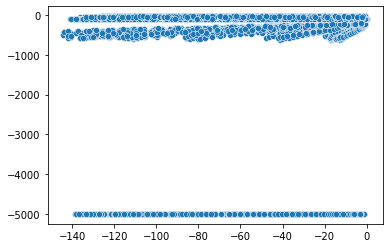

In [ ]:
import seaborn as sns

preds = np.zeros_like(train_list_y[0])
for i, row in enumerate(train_list_X[0]):
    preds[i] = np.clip(f(*row)[0], -5000, 5000)

sns.scatterplot(train_list_y[0], preds)

In [ ]:
'zeides_2a_8_red_2000_cal_10_vel_10_fric_025',
'zeides_2a_8_red_2000_cal_75_vel_10_fric_050',
'zeides_2a_8_red_2500_cal_30_vel_10_fric_0100',
'zeides_2a_8_red_250_cal_0_vel_10_fric_025',
'zeides_2a_8_red_2000_cal_30_vel_10_fric_050'